**Importing libraries and downloading data and connecting with Google Drive**

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import gc
import cv2
import time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, LearningRateScheduler, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"manossokorelis","key":"06c3bcf0f8e00aaa0164d79531dc7408"}'}

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [ ]:
!kaggle datasets download -d sid321axn/covid-cxr-image-dataset-research

Dataset URL: https://www.kaggle.com/datasets/sid321axn/covid-cxr-image-dataset-research
License(s): CC0-1.0
100% 571M/572M [00:25<00:00, 24.8MB/s]
100% 572M/572M [00:25<00:00, 23.2MB/s]


In [ ]:
!unzip \*.zip

Archive:  covid-cxr-image-dataset-research.zip
  inflating: COVID_IEEE/covid/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg  
  inflating: COVID_IEEE/covid/03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg  
  inflating: COVID_IEEE/covid/1-s2.0-S0140673620303706-fx1_lrg.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-a.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-b.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-c.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-d.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300608-main.pdf-001.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300608-main.pdf-002.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-002-a1.png  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-002-a2.png  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-003-b1.png  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-003-b2.pn

**Some visualization**

In [ ]:
def view_image(target_dir, target_class):
  target_folder = target_dir + target_class
  random_image = random.sample(os.listdir(target_folder), 1)
  print(random_image)
  img = mpimg.imread(target_folder + '/' + random_image[0])
  plt.imshow(img, cmap='gray')
  plt.title(target_class)
  plt.axis('off')
  print(f'image shape {img.shape}')
  return img

['person616_virus_1186.jpeg']
image shape (800, 1464)


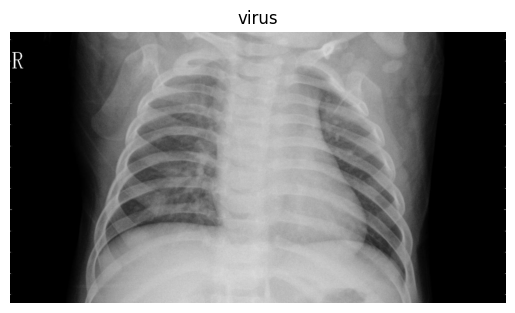

In [ ]:
img = view_image('/content/COVID_IEEE/','virus')

['IM-0381-0001.jpeg']
image shape (1388, 1744)


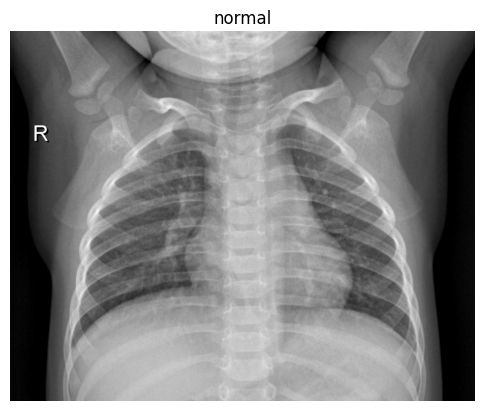

In [ ]:
img = view_image('/content/COVID_IEEE/','normal')

['covid1900483.png']
image shape (480, 640, 3)


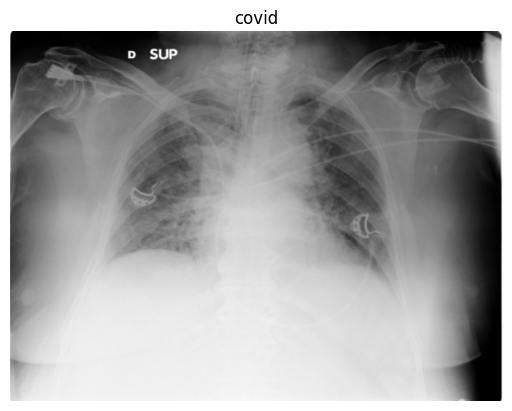

In [ ]:
img = view_image('/content/COVID_IEEE/','covid')

**Creating dataset**

In [ ]:
def create_dataset(path0, path1, path2):
  images = []
  labels = []
  load_images(path0, 0, images, labels)
  load_images(path1, 1, images, labels)
  load_images(path2, 2, images, labels)
  images = np.array(images)
  labels = np.array(labels)
  return images, labels

def load_images(path, label, images, labels):
  for filename in os.listdir(path):
    image = cv2.imread(os.path.join(path, filename))
    if image is not None:
      image = cv2.resize(image, (224, 224))
      images.append(image)
      labels.append(label)

path0 = '/content/COVID_IEEE/covid/'
path1 = '/content/COVID_IEEE/normal/'
path2 = '/content/COVID_IEEE/virus/'

images, labels = create_dataset(path0, path1, path2)

**Defining models architecture**

In [ ]:
class ResNet50Model(Model):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.base_model = tf.keras.applications.ResNet50(input_shape=[224,224,3], weights='imagenet', include_top=False)
    for layer in self.base_model.layers:
      layer.trainable = False
    self.flatten = Flatten()
    self.dense1 = Dense(units=1024, activation='relu')
    self.dense2 = Dense(units=512, activation='relu')
    self.dense3 = Dense(units=256, activation='relu')
    self.prediction_layer = Dense(units=3, activation='softmax')

  def call(self, inputs):
    x = self.base_model(inputs)
    x = self.flatten(x)
    x = self.dense1(x)
    x = self.dense2(x)
    x = self.dense3(x)
    output = self.prediction_layer(x)
    return output

In [ ]:
class DenseNet201Model(Model):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.base_model = tf.keras.applications.DenseNet201(input_shape=[224,224,3], weights='imagenet', include_top=False)
    for layer in self.base_model.layers:
      layer.trainable = False
    self.flatten = Flatten()
    self.dense1 = Dense(units=1024, activation='relu')
    self.dense2 = Dense(units=512, activation='relu')
    self.dense3 = Dense(units=256, activation='relu')
    self.prediction_layer = Dense(units=3, activation='softmax')

  def call(self, inputs):
    x = self.base_model(inputs)
    x = self.flatten(x)
    x = self.dense1(x)
    x = self.dense2(x)
    x = self.dense3(x)
    output = self.prediction_layer(x)
    return output

In [ ]:
class InceptionResNetV2Model(Model):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.base_model = tf.keras.applications.InceptionResNetV2(input_shape=[224,224,3], weights='imagenet', include_top=False)
    for layer in self.base_model.layers:
      layer.trainable = False
    self.flatten = Flatten()
    self.dense1 = Dense(units=1024, activation='relu')
    self.dense2 = Dense(units=512, activation='relu')
    self.dense3 = Dense(units=256, activation='relu')
    self.prediction_layer = Dense(units=3, activation='softmax')

  def call(self, inputs):
    x = self.base_model(inputs)
    x = self.flatten(x)
    x = self.dense1(x)
    x = self.dense2(x)
    x = self.dense3(x)
    output = self.prediction_layer(x)
    return output

In [ ]:
class MobileNetV2Model(Model):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.base_model = tf.keras.applications.MobileNetV2(input_shape=[224,224,3], weights='imagenet', include_top=False)
    for layer in self.base_model.layers:
      layer.trainable = False
    self.flatten = Flatten()
    self.dense1 = Dense(units=1024, activation='relu')
    self.dense2 = Dense(units=512, activation='relu')
    self.dense3 = Dense(units=256, activation='relu')
    self.prediction_layer = Dense(units=3, activation='softmax')

  def call(self, inputs):
    x = self.base_model(inputs)
    x = self.flatten(x)
    x = self.dense1(x)
    x = self.dense2(x)
    x = self.dense3(x)
    output = self.prediction_layer(x)
    return output

**Defining some custom function and callbacks for taking metrics**

In [ ]:
class CustomCallback(Callback):
  def __init__(self, model, fold_idx):
    super(CustomCallback, self).__init__()
    self.custom_model = model
    self.fold_idx = fold_idx
    self.start_time = None
    self.end_time = None

  def on_train_begin(self, logs=None):
    self.start_time = time.time()

  def on_train_end(self, logs=None):
    global time_metrics
    self.end_time = time.time()
    time_metrics = pd.concat([time_metrics, pd.DataFrame({
        'Model': [type(self.custom_model).__name__],
        'Time': [self.end_time - self.start_time]
    })], ignore_index=True)

  def on_epoch_end(self, epoch, logs=None):
      global train_metrics
      train_loss = logs.get('loss')
      train_accuracy = logs.get('accuracy')
      val_loss = logs.get('val_loss')
      val_accuracy = logs.get('val_accuracy')
      train_metrics = pd.concat([train_metrics, pd.DataFrame({
          'Model': [type(self.custom_model).__name__],
          'Fold': [self.fold_idx + 1],
          'Epoch': [epoch + 1],
          'Loss': [train_loss],
          'Accuracy': [train_accuracy],
          'Val_Loss': [val_loss],
          'Val_Accuracy': [val_accuracy]
      })], ignore_index=True)

In [ ]:
def calculate_metrics(test_lbls, test_lbls_pred, model, fold_idx):
  global test_metrics
  accuracy = accuracy_score(test_lbls, test_lbls_pred)
  precision = precision_score(test_lbls, test_lbls_pred, average='weighted')
  recall = recall_score(test_lbls, test_lbls_pred, average='weighted')
  f1 = f1_score(test_lbls, test_lbls_pred, average='weighted')
  test_metrics = pd.concat([test_metrics, pd.DataFrame({
    'Model': [type(model).__name__],
    'Fold': [fold_idx+1],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1-Score': [f1]
  })], ignore_index=True)

In [ ]:
def createPlot(model, fold):
  data = train_metrics[train_metrics['Model'] == model]
  data = data[data['Fold'] == fold]
  fig, axs = plt.subplots(1, 2, figsize=(18, 8))
  axs[0].plot(data['Epoch'], data['Loss'], label='Training Loss', marker='o')
  axs[0].plot(data['Epoch'], data['Val_Loss'], label='Validation Loss', marker='o')
  axs[0].set_title('Training and Validation Loss per Epoch')
  axs[0].set_xlabel('Epoch')
  axs[0].set_ylabel('Loss')
  axs[0].legend()
  axs[0].grid(True)
  axs[1].plot(data['Epoch'], data['Accuracy'], label='Training Accuracy', marker='o')
  axs[1].plot(data['Epoch'], data['Val_Accuracy'], label='Validation Accuracy', marker='o')
  axs[1].set_title('Training and Validation Accuracy per Epoch')
  axs[1].set_xlabel('Epoch')
  axs[1].set_ylabel('Accuracy')
  axs[1].legend()
  axs[1].grid(True)
  fig.suptitle(f'Training and Validation Metrics per Epoch for {model} (Fold {fold})', fontsize=16)
  plt.show()

In [ ]:
def createAvgPlot():
  models = ['DenseNet201Model', 'InceptionResNetV2Model', 'MobileNetV2Model', 'ResNet50Model']
  data = avg_train_metrics[avg_train_metrics['Model'].isin(models)]
  plt.figure(figsize=(18, 6))
  colors = ['b', 'g', 'r', 'c']
  for i, model in enumerate(models):
    model_data = data[data['Model'] == model]
    plt.plot(model_data['Epoch'], model_data['Val_Accuracy'], marker='o', linestyle='-', color=colors[i], label=f'{model}')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)
  plt.show()
  plt.figure(figsize=(18, 8))
  for i, model in enumerate(models):
    model_data = data[data['Model'] == model]
    plt.plot(model_data['Epoch'], model_data['Val_Loss'], marker='o', linestyle='-', color=colors[i], label=f'{model}')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.show()

**Data preprocessing**

In [ ]:
images = images / 255.0
main_imgs, test_imgs, main_lbls, test_lbls = train_test_split(images, labels, test_size=0.2, random_state=42)

**Creating dataframes for storage**

In [ ]:
train_metrics_columns = ['Model', 'Fold', 'Epoch' , 'Loss', 'Accuracy', 'Val_Loss', 'Val_Accuracy']
train_metrics = pd.DataFrame(columns=train_metrics_columns)
time_metrics_column = ['Model', 'Time']
time_metrics = pd.DataFrame(columns=time_metrics_column)
test_metrics_columns = ['Model', 'Fold', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
test_metrics = pd.DataFrame(columns=test_metrics_columns)

**Define some parameters**


In [ ]:
epochs = 10
n_splits = 5

**Testing**

In [ ]:
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold_idx, (train_index, val_index) in enumerate(stratified_kfold.split(main_imgs, main_lbls)):
  print(f'- Fold {fold_idx+1}:')
  train_imgs_fold = main_imgs[train_index]
  train_lbls_fold = main_lbls[train_index]
  val_imgs_fold = main_imgs[val_index]
  val_lbls_fold = main_lbls[val_index]
  train_lbls_fold = tf.keras.utils.to_categorical(train_lbls_fold, num_classes = 3)
  val_lbls_fold = tf.keras.utils.to_categorical(val_lbls_fold, num_classes = 3)
  for ModelClass in [ResNet50Model, DenseNet201Model, InceptionResNetV2Model, MobileNetV2Model]:
    print(f'Model {ModelClass.__name__}:')
    model = ModelClass()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(
      train_imgs_fold, train_lbls_fold,
      epochs=epochs,
      validation_data=(val_imgs_fold, val_lbls_fold),
      callbacks=[CustomCallback(model, fold_idx),
                EarlyStopping(
                  patience=15,
                  min_delta=0.01,
                  mode='min',
                  monitor='val_loss',
                  restore_best_weights=True,
                  verbose=0)
                ])
    test_lbls_pred = np.argmax(model.predict(test_imgs), axis = 1)
    calculate_metrics(test_lbls, test_lbls_pred, model, fold_idx)
    del model
    gc.collect()
  print(20*'-')
train_metrics = train_metrics.sort_values(by=['Model', 'Fold', 'Epoch'])
time_metrics = time_metrics.sort_values(by=['Model'])
test_metrics = test_metrics.sort_values(by=['Model', 'Fold'])
train_metrics.to_csv('train_metrics.csv', index=False)
time_metrics.to_csv('time_metrics.csv', index=False)
test_metrics.to_csv('testd_metrics.csv', index=False)
train_metrics.to_excel('train_metrics.xlsx', index=False)
time_metrics.to_excel('time_metrics.xlsx', index=False)
test_metrics.to_excel('test_metrics.xlsx', index=False)
avg_train_metrics = train_metrics.groupby(['Model', 'Epoch']).mean().reset_index().drop(columns=['Fold'])
avg_time_metrics = time_metrics.groupby('Model')['Time'].mean().reset_index()
avg_test_metrics = test_metrics.groupby('Model')[['Accuracy', 'Precision', 'Recall', 'F1-Score']].mean().reset_index()
avg_train_metrics.to_csv('avg_train_metrics.csv', index=False)
avg_time_metrics.to_csv('avg_time_metrics.csv', index=False)
avg_test_metrics.to_csv('avg_test_metrics.csv', index=False)
avg_train_metrics.to_excel('avg_train_metrics.xlsx', index=False)
avg_time_metrics.to_excel('avg_time_metrics.xlsx', index=False)
avg_test_metrics.to_excel('avg_test_metrics.xlsx', index=False)

- Fold 1:
Model ResNet50Model:
Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.3547 - loss: 8.3368

<ipython-input-15-c1f9d6ca5cf4>:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_metrics = pd.concat([train_metrics, pd.DataFrame({


37/37 ━━━━━━━━━━━━━━━━━━━━ 37s 566ms/step - accuracy: 0.3554 - loss: 8.2427 - val_accuracy: 0.5959 - val_loss: 0.8383
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.5572 - loss: 0.9012 - val_accuracy: 0.5171 - val_loss: 0.8378
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step - accuracy: 0.6469 - loss: 0.7208 - val_accuracy: 0.7021 - val_loss: 0.6237
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.7068 - loss: 0.6274 - val_accuracy: 0.8116 - val_loss: 0.5378
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.7682 - loss: 0.5293 - val_accuracy: 0.7774 - val_loss: 0.5236
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.8013 - loss: 0.5069 - val_accuracy: 0.6507 - val_loss: 0.7016
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.7769 - loss: 0.5286 - val_accuracy: 0.8151 - val_loss: 0.5310
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.8186 - loss: 0.4235 - val_accuracy: 0.8151 - v

<ipython-input-15-c1f9d6ca5cf4>:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  time_metrics = pd.concat([time_metrics, pd.DataFrame({


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 540ms/step


<ipython-input-16-423dfbc9b156>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test_metrics = pd.concat([test_metrics, pd.DataFrame({


Model DenseNet201Model:
Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.6232 - loss: 12.2931 - val_accuracy: 0.9349 - val_loss: 0.4711
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 48s 257ms/step - accuracy: 0.9394 - loss: 0.3944 - val_accuracy: 0.9281 - val_loss: 0.4585
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 168ms/step - accuracy: 0.9570 - loss: 0.2349 - val_accuracy: 0.9452 - val_loss: 0.4601
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 221ms/step - accuracy: 0.9816 - loss: 0.0770 - val_accuracy: 0.9521 - val_loss: 0.3180
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - accuracy: 0.9856 - loss: 0.0530 - val_accuracy: 0.9452 - val_loss: 0.3937
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 262ms/step - accuracy: 0.9926 - loss: 0.0239 - val_accuracy: 0.9486 - val_loss: 0.2919
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - accuracy: 0.9980 - loss: 0.0030 - val_accuracy: 0.9589 - val_loss: 0.2926
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - accuracy: 1.0000 - loss

**Show metrics**

In [ ]:
train_metrics

In [ ]:
time_metrics

In [ ]:
test_metrics

In [ ]:
avg_train_metrics

In [ ]:
avg_time_metrics

In [ ]:
avg_test_metrics